使用字符级分词 (Using character-level tokenizer)
构建了大小为 60 的字符级词汇表。
构建了大小为 64 的字符级词汇表。


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1: Train Loss=1.4160, Train Acc=0.5748, Valid Loss=0.9924, Valid Acc=0.6937
Epoch 2: Train Loss=0.9845, Train Acc=0.6952, Valid Loss=0.8402, Valid Acc=0.7353
Epoch 3: Train Loss=0.8786, Train Acc=0.7263, Valid Loss=0.7709, Valid Acc=0.7581
Epoch 4: Train Loss=0.8200, Train Acc=0.7435, Valid Loss=0.7254, Valid Acc=0.7717
Epoch 5: Train Loss=0.7803, Train Acc=0.7553, Valid Loss=0.6991, Valid Acc=0.7814


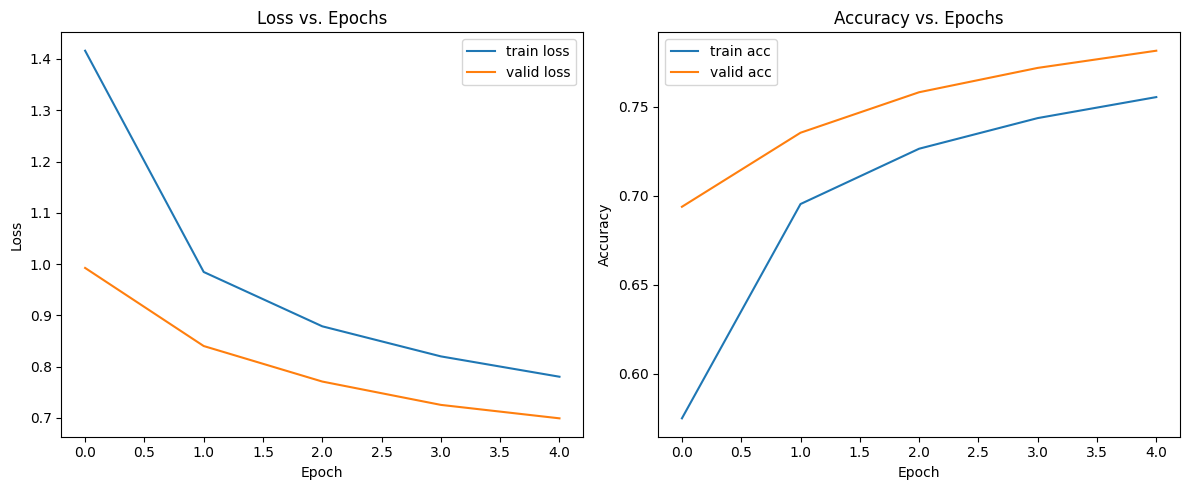


Final Test Loss: 0.8510, Test Acc: 0.7329

[德语原文]  frauen spielen mit einem orangenen ball lacrosse .
[德语ID序列]  [1, 35, 47, 30, 50, 34, 43, 4, 48, 45, 38, 34, 41, 34, 43, 4, 42, 38, 49, 4, 34, 38, 43, 34, 42, 4, 44, 47, 30, 43, 36, 34, 43, 34, 43, 4, 31, 30, 41, 41] ...
[德语分词(Char)]  ['<sos>', 'f', 'r', 'a', 'u', 'e', 'n', ' ', 's', 'p', 'i', 'e', 'l', 'e', 'n', ' ', 'm', 'i', 't', ' ', 'e', 'i', 'n', 'e', 'm', ' ', 'o', 'r', 'a', 'n', 'g', 'e', 'n', 'e', 'n', ' ', 'b', 'a', 'l', 'l']

=== 随机测试集翻译示例 ===
源 (Source): ein gelber hund im freien mit papier im maul .
参考 (Target): un chien jaune dehors avec du papier dans sa gueule .
预测 (Predicted): un chien blanc sur un trottoir dans la rue .
----------------------------------------
源 (Source): menschengruppe , die einen turm aus menschen bildet
参考 (Target): un groupe de personnes faisant une tour humaine
预测 (Predicted): des gens se rassemblent dans une rue avec des cha
----------------------------------------
源 (Source): ein motorradfahrer

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
德语 -> 法语 Transformer 翻译实验
Task-3 子任务2：实现 Transformer 基础结构 + 语言模型学习
支持 词(word), BPE, 和 字符(char) 三种分词方式，并可调整词表大小
"""

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sentencepiece as spm
import random
from collections import Counter # --- 新增: 用于词频统计 ---

# ========== 宏定义参数 (Hyperparameters) ==========
PARAMS = {
    "TOKENIZER_TYPE": "char",   # 可选 "word", "bpe", 或 "char" (Choose "word", "bpe", or "char")
    "VOCAB_SIZE": 29236,        # --- 控制词级别和BPE的词表大小 ---
    # --- 修改: 使用模型前缀，完整文件名将自动生成 ---
    "SRC_MODEL_PREFIX": "spm_de",
    "TGT_MODEL_PREFIX": "spm_fr",
    "MAX_LEN": 50,
    "BATCH_SIZE": 32,
    "EMBED_DIM": 128,
    "NHEAD": 4,
    "NUM_LAYERS": 2,
    "LR": 1e-3,
    "EPOCHS": 5,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
}

# --- 数据文件路径 (Data file paths) ---
DATA_DIR = "data/de_fr"
# ... (代码与之前相同)
if not os.path.exists(DATA_DIR):
    print(f"警告：数据文件夹 {DATA_DIR} 不存在。请创建并放入数据文件。")
    print("Warning: Data directory not found. Please create it and add data files.")
    os.makedirs(DATA_DIR, exist_ok=True)
    dummy_files = ["train.de", "train.fr", "val.de", "val.fr", "test.de", "test.fr"]
    for fname in dummy_files:
        with open(os.path.join(DATA_DIR, fname), "w", encoding="utf-8") as f:
            f.write("ein beispiel satz .\n")
            f.write("ein anderer beispiel satz .\n")

TRAIN_SRC = os.path.join(DATA_DIR, "train.de")
TRAIN_TGT = os.path.join(DATA_DIR, "train.fr")
VALID_SRC = os.path.join(DATA_DIR, "val.de")
VALID_TGT = os.path.join(DATA_DIR, "val.fr")
TEST_SRC = os.path.join(DATA_DIR, "test.de")
TEST_TGT = os.path.join(DATA_DIR, "test.fr")


# ========== 数据读取 (Data Loading) & 工具函数 ==========
def load_parallel_corpus(src_file, tgt_file):
    """读取平行语料库"""
    try:
        with open(src_file, encoding="utf-8") as f_src, open(tgt_file, encoding="utf-8") as f_tgt:
            src_lines = [line.strip() for line in f_src]
            tgt_lines = [line.strip() for line in f_tgt]
        assert len(src_lines) == len(tgt_lines), "Source and target language file sizes do not match."
        return list(zip(src_lines, tgt_lines))
    except FileNotFoundError:
        print(f"Error: File not found at {src_file} or {tgt_file}.")
        return []

def calculate_accuracy(pred, target, pad_idx=0):
    """计算准确率，忽略padding部分"""
    pred_tokens = pred.argmax(dim=-1)
    correct_mask = (pred_tokens == target)
    pad_mask = (target != pad_idx)
    
    correct_tokens = (correct_mask & pad_mask).sum().float()
    total_tokens = pad_mask.sum().float()
    
    return (correct_tokens / total_tokens).item() if total_tokens > 0 else 0


# ========== Tokenizer ==========
# ... (BPETokenizer, SimpleTokenizer, CharTokenizer 代码与之前相同)
class BPETokenizer:
    """BPE 分词器 (SentencePiece)"""
    def __init__(self, model_file):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_file)

    def encode(self, text, max_len=None):
        ids = [1] + self.sp.encode(text, out_type=int) + [2]  # <sos>=1, <eos>=2
        if max_len:
            padding = [0] * (max_len - len(ids))
            ids = (ids + padding)[:max_len]
        return ids

    def decode(self, ids):
        return self.sp.decode([i for i in ids if i not in (0, 1, 2)])

    def vocab_size(self):
        return self.sp.get_piece_size()

class SimpleTokenizer:
    """基于词汇表的简单分词器"""
    def __init__(self, vocab):
        self.word2idx = {word: i for i, word in enumerate(vocab, start=4)}
        self.word2idx["<pad>"] = 0
        self.word2idx["<sos>"] = 1
        self.word2idx["<eos>"] = 2
        self.word2idx["<unk>"] = 3
        self.idx2word = {i: word for word, i in self.word2idx.items()}

    def encode(self, text, max_len=None):
        ids = [1] + [self.word2idx.get(w, 3) for w in text.split()] + [2]
        if max_len:
            padding = [0] * (max_len - len(ids))
            ids = (ids + padding)[:max_len]
        return ids

    def decode(self, ids):
        return " ".join([self.idx2word.get(i, "<unk>") for i in ids if i not in (0, 1, 2)])

    def vocab_size(self):
        return len(self.word2idx)

class CharTokenizer:
    """基于字符的简单分词器"""
    def __init__(self, vocab):
        self.char2idx = {char: i for i, char in enumerate(vocab, start=4)}
        self.char2idx["<pad>"] = 0
        self.char2idx["<sos>"] = 1
        self.char2idx["<eos>"] = 2
        self.char2idx["<unk>"] = 3
        self.idx2char = {i: char for char, i in self.char2idx.items()}

    def encode(self, text, max_len=None):
        ids = [1] + [self.char2idx.get(c, 3) for c in text] + [2]
        if max_len:
            padding = [0] * (max_len - len(ids))
            ids = (ids + padding)[:max_len]
        return ids

    def decode(self, ids):
        return "".join([self.idx2char.get(i, "") for i in ids if i not in (0, 1, 2)])

    def vocab_size(self):
        return len(self.char2idx)


# ========== Dataset & Model & Training & Inference ==========
# ... (这部分代码与之前相同)
class TranslationDataset(Dataset):
    def __init__(self, data, src_tok, tgt_tok, max_len=50):
        self.data = data
        self.src_tok = src_tok
        self.tgt_tok = tgt_tok
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        src_ids = self.src_tok.encode(src, self.max_len)
        tgt_ids = self.tgt_tok.encode(tgt, self.max_len)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

class TransformerMT(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, embed_dim, nhead, num_layers):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab, embed_dim)
        self.tgt_emb = nn.Embedding(tgt_vocab, embed_dim)
        self.pos_encoder = nn.Embedding(512, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, tgt_vocab)

    def forward(self, src, tgt):
        device = src.device
        src_len = src.size(1)
        tgt_len = tgt.size(1)

        src_padding_mask = (src == 0)
        tgt_padding_mask = (tgt == 0)

        src_pos = torch.arange(0, src_len, device=device).unsqueeze(0)
        src_embedded = self.src_emb(src) + self.pos_encoder(src_pos)

        tgt_pos = torch.arange(0, tgt_len, device=device).unsqueeze(0)
        tgt_embedded = self.tgt_emb(tgt) + self.pos_encoder(tgt_pos)

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)

        memory = self.encoder(src_embedded, src_key_padding_mask=src_padding_mask)
        out = self.decoder(
            tgt_embedded,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask
        )
        return self.fc_out(out)

def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            optimizer.zero_grad()
            output = model(src, tgt_input)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += calculate_accuracy(output, tgt_output)

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        avg_valid_loss, avg_valid_acc = evaluate(model, valid_loader, criterion, device)

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        train_accs.append(avg_train_acc)
        valid_accs.append(avg_valid_acc)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f}, "
              f"Valid Loss={avg_valid_loss:.4f}, Valid Acc={avg_valid_acc:.4f}")
    return train_losses, valid_losses, train_accs, valid_accs

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))

            total_loss += loss.item()
            total_acc += calculate_accuracy(output, tgt_output)
    return total_loss / len(loader), total_acc / len(loader)

def greedy_decode(model, src, src_tok, tgt_tok, max_len=50, device="cuda"):
    model.eval()
    src_ids = torch.tensor([src_tok.encode(src, max_len)], device=device)
    src_padding_mask = (src_ids == 0)

    with torch.no_grad():
        src_pos = torch.arange(0, src_ids.size(1), device=device).unsqueeze(0)
        memory = model.encoder(
            model.src_emb(src_ids) + model.pos_encoder(src_pos),
            src_key_padding_mask=src_padding_mask
        )
    
    sos_id, eos_id = 1, 2
    ys = torch.tensor([[sos_id]], device=device)
    for _ in range(max_len - 1):
        with torch.no_grad():
            tgt_pos = torch.arange(0, ys.size(1), device=device).unsqueeze(0)
            tgt_embedded = model.tgt_emb(ys) + model.pos_encoder(tgt_pos)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(ys.size(1)).to(device)

            out = model.decoder(tgt_embedded, memory, tgt_mask=tgt_mask, memory_key_padding_mask=src_padding_mask)
            out = model.fc_out(out)
            next_word = out[:, -1, :].argmax(dim=-1).item()
        
        ys = torch.cat([ys, torch.tensor([[next_word]], device=device)], dim=1)
        if next_word == eos_id:
            break
    return tgt_tok.decode(ys[0].tolist())

def show_translations(model, src_tok, tgt_tok, data, device="cuda", n=10):
    """展示翻译样本"""
    if not data: return
    model.eval()
    samples = random.sample(data, min(n, len(data)))
    for src_text, tgt_text in samples:
        pred = greedy_decode(model, src_text, src_tok, tgt_tok, device=device, max_len=PARAMS["MAX_LEN"])
        print(f"源 (Source): {src_text}")
        print(f"参考 (Target): {tgt_text}")
        print(f"预测 (Predicted): {pred}")
        print("-" * 40)

def show_tokenization_examples(src_tok, tgt_tok, data, n=5, max_len=50):
    """展示分词效果"""
    if not data: return
    samples = random.sample(data, min(n, len(data)))
    for src, tgt in samples:
        src_ids = src_tok.encode(src, max_len)
        print(f"\n[德语原文]  {src}")
        print(f"[德语ID序列]  {src_ids[:40]} ...")
        
        if isinstance(src_tok, BPETokenizer):
            print("[德语分词(BPE)] ", [src_tok.sp.id_to_piece(i) for i in src_ids if i != 0][:40])
        elif isinstance(src_tok, SimpleTokenizer):
            print("[德语分词(Word)] ", [src_tok.idx2word.get(i, "<unk>") for i in src_ids if i != 0][:40])
        elif isinstance(src_tok, CharTokenizer):
            print("[德语分词(Char)] ", [src_tok.idx2char.get(i, "<unk>") for i in src_ids if i != 0][:40])


# ========== SentencePiece 训练函数 (SentencePiece Trainer) ==========
# --- 修改: 根据词表大小自动生成和检查模型文件 ---
def train_sentencepiece(input_file, model_prefix, vocab_size=10000, model_type="bpe"):
    # 根据词表大小生成完整模型路径前缀
    model_path_prefix = f"{model_prefix}_{vocab_size}"
    model_file = model_path_prefix + ".model"

    if not os.path.exists(model_file):
        print(f"Training SentencePiece model: {model_path_prefix} with vocab size {vocab_size}")
        spm.SentencePieceTrainer.Train(
            f"--input={input_file} --model_prefix={model_path_prefix} "
            f"--vocab_size={vocab_size} --model_type={model_type} "
            f"--bos_id=1 --eos_id=2 --unk_id=3 --pad_id=0"
        )
    else:
        print(f"Found existing model: {model_file}")


# ========== 词汇表构建函数 (Vocabulary Builder) ==========
# --- 修改: 接受 vocab_size 参数，并按词频构建 ---
def build_vocab(corpus, level='word', vocab_size=10000):
    """根据语料构建词汇表"""
    tokens = set()
    if level == 'word':
        # 统计词频
        word_freq = Counter(word for sentence in corpus for word in sentence.split())
        # 获取最常见的 N-4 个词 (为 <pad>, <sos>, <eos>, <unk> 留出位置)
        most_common_words = [word for word, freq in word_freq.most_common(vocab_size - 4)]
        print(f"从 {len(word_freq)} 个独立单词中，构建了大小为 {len(most_common_words)} 的词汇表。")
        return sorted(most_common_words)
    elif level == 'char':
        for sentence in corpus:
            tokens.update(list(sentence))
        print(f"构建了大小为 {len(tokens)} 的字符级词汇表。")
        return sorted(list(tokens))


# ========== 主程序 (Main Program) ==========
def main():
    train_data = load_parallel_corpus(TRAIN_SRC, TRAIN_TGT)
    valid_data = load_parallel_corpus(VALID_SRC, VALID_TGT)
    test_data = load_parallel_corpus(TEST_SRC, TEST_TGT)
    
    if not train_data:
        print("Training data is empty. Halting program. Please check data file paths and content.")
        return

    # 分词器
    if PARAMS["TOKENIZER_TYPE"] == "bpe":
        # --- 修改: 根据词表大小生成模型文件名 ---
        src_model_file = f"{PARAMS['SRC_MODEL_PREFIX']}_{PARAMS['VOCAB_SIZE']}.model"
        tgt_model_file = f"{PARAMS['TGT_MODEL_PREFIX']}_{PARAMS['VOCAB_SIZE']}.model"

        print(f"使用 BPE 分词，词表大小: {PARAMS['VOCAB_SIZE']}")
        # --- 修改: 传入模型文件前缀 ---
        train_sentencepiece(TRAIN_SRC, PARAMS["SRC_MODEL_PREFIX"], vocab_size=PARAMS["VOCAB_SIZE"])
        train_sentencepiece(TRAIN_TGT, PARAMS["TGT_MODEL_PREFIX"], vocab_size=PARAMS["VOCAB_SIZE"])
        # --- 修改: 加载带词表大小后缀的模型 ---
        src_tok = BPETokenizer(src_model_file)
        tgt_tok = BPETokenizer(tgt_model_file)
        
    elif PARAMS["TOKENIZER_TYPE"] == "char":
        print("使用字符级分词 (Using character-level tokenizer)")
        src_vocab = build_vocab([s for s,_ in train_data], level='char')
        tgt_vocab = build_vocab([t for _,t in train_data], level='char')
        src_tok = CharTokenizer(src_vocab)
        tgt_tok = CharTokenizer(tgt_vocab)
    else: # 默认为 "word"
        print(f"使用词级分词，词表大小: {PARAMS['VOCAB_SIZE']}")
        src_vocab = build_vocab([s for s,_ in train_data], level='word', vocab_size=PARAMS['VOCAB_SIZE'])
        tgt_vocab = build_vocab([t for _,t in train_data], level='word', vocab_size=PARAMS['VOCAB_SIZE'])
        src_tok = SimpleTokenizer(src_vocab)
        tgt_tok = SimpleTokenizer(tgt_vocab)

    # Dataset & Loader, Model, Training...
    # (这部分代码无需改动)
    train_dataset = TranslationDataset(train_data, src_tok, tgt_tok, PARAMS["MAX_LEN"])
    valid_dataset = TranslationDataset(valid_data, src_tok, tgt_tok, PARAMS["MAX_LEN"])
    test_dataset = TranslationDataset(test_data, src_tok, tgt_tok, PARAMS["MAX_LEN"])

    train_loader = DataLoader(train_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=PARAMS["BATCH_SIZE"])
    test_loader = DataLoader(test_dataset, batch_size=PARAMS["BATCH_SIZE"])

    model = TransformerMT(
        src_vocab=src_tok.vocab_size(),
        tgt_vocab=tgt_tok.vocab_size(),
        embed_dim=PARAMS["EMBED_DIM"],
        nhead=PARAMS["NHEAD"],
        num_layers=PARAMS["NUM_LAYERS"]
    ).to(PARAMS["DEVICE"])

    optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS["LR"])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    train_losses, valid_losses, train_accs, valid_accs = train_model(
        model, train_loader, valid_loader, optimizer, criterion,
        PARAMS["EPOCHS"], PARAMS["DEVICE"]
    )

    # 可视化
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="train acc")
    plt.plot(valid_accs, label="valid acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epochs")
    plt.tight_layout()
    plt.show()

    test_loss, test_acc = evaluate(model, test_loader, criterion, PARAMS["DEVICE"])
    print(f"\nFinal Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    show_tokenization_examples(src_tok, tgt_tok, test_data, n=1, max_len=PARAMS["MAX_LEN"])

    print("\n=== 随机测试集翻译示例 ===")
    show_translations(model, src_tok, tgt_tok, test_data, device=PARAMS["DEVICE"], n=10)


if __name__ == "__main__":
    main()

